<a href="https://colab.research.google.com/github/poudyaldiksha/Data-Science-project/blob/main/Lesson_38_b2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 38: Simple Linear Regression II

---

### Recap

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = '/content/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')

# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int32         
 11  Month          9357 non-null   int32         
 12  Day            9357 non-null   int32         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int32(3), object(1)
memory usage: 986.9+ KB

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

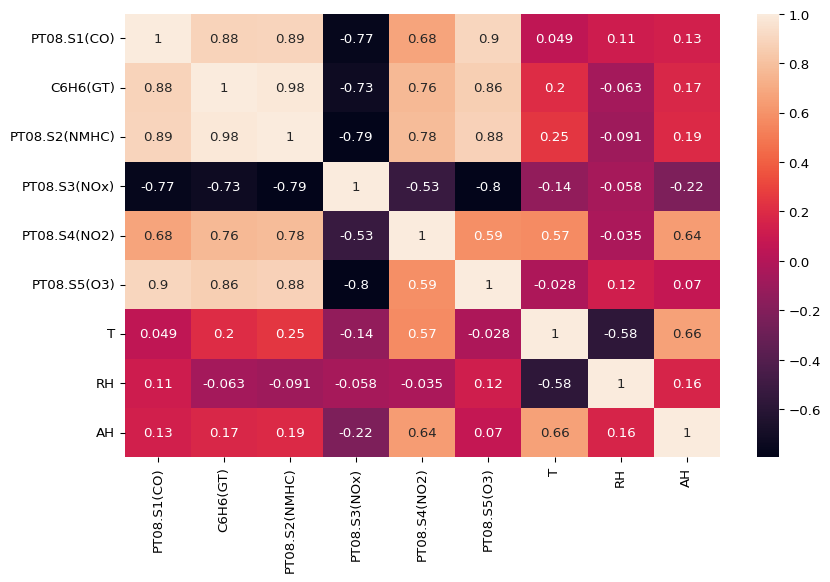

In [ ]:
# Heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

---

#### Activity 1: Slope & Intercept

Before we learn linear regression, we need to know the equation of a straight line. We have already learned the slope of a line.

It is given as *the tangent of the angle made by a straight line with $x$-axis in the anti-clockwise (or counter-clockwise) direction*.

Consider the straight line shown below. Let its equation be

$$y = mx + c$$

where

- $y$ is the $y$-coordinate of the point lying on the line

- $x$ is the $x$-coordinate of the point lying on the line

- $m$ is the slope of the line

- $c$ is the intercept made by the line on the $y$-axis

**Note:** The above form of the equation of a straight line is called **slope-intercept** form. There are other forms as well. But for the sake of learning linear regression, we will stick to the **slope-intercept** form only.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/eq-st-line1.png' width = 700></center>

Here, the straight line intersects with $x$-axis at point $A$ and makes an angle $\theta$ in the anti-clockwise direction as indicated by the arrowhead of the curved red line.

So $$\angle BAP = \theta$$

Let $B(5, 2)$ and $C(7, 4)$ be any two arbitrary points on the line.

Since $RD \parallel OQ$ and the straight line $y = mx + c$ is the transversal line, therefore $\angle CBD = \angle BAP$ because they are corresponding angles.

Hence, in the right-angled triangle $CBD$, $\angle CBD = \theta$, $CD$ is the perpendicular and $DB$ is the base.

$$\therefore m = \tan \theta = \frac{CD}{DB} = \frac{2}{2} = 1$$

So, the slope of the straight line $y = mx + c$ is $m = \tan \theta = 1$.

Therefore, the equation of the line is $$y = x + c$$

Now $c$ is an unknown quantity, i.e., the $y$-coordinate of point $E$. To find $c$, substitute either $(5, 2)$ or $(7, 4)$ in the equation of line because these two points lie on the line.

So,

$$2 = 5 + c \Rightarrow c = -3$$

Therefore, the equation of the line is $$y = x - 3$$

Also, the coordinates of the point $E$ are $(0, -3)$.

**Zero Slope**

Notice that the equations for the straight lines:

- $RD$ can be written as $y = 2$ with slope $m = \tan 0^{\circ} = 0$

- $SC$ can be written as $y = 4$ with slope $m = \tan 0^{\circ} = 0$

as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/eq-st-line2.png' width = 700></center>


**Undefined (Not Defined) Slope**

Similarly, the equations for the straight lines:

- $BP$ can be written as $x = 5$ with slope $m = \tan 90^{\circ} = \text{undefined}$

- $CQ$ can be written as $x = 7$ with slope $m = \tan 90^{\circ} = \text{undefined}$

as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/eq-st-line3.png' width = 700></center>


Let's look at the fourth case where the slope of a straight line is **negative** because the angle created by the line with $x$-axis is obtuse, i.e., $\theta > 90^{\circ}$ as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/eq-st-line4.png' width = 700></center>

Let the equation of line be $$y = mx + c$$

Let $B(5, 3)$ and $C(1, 6)$ be any two arbitrary points on the line.

Here
$$\angle BAQ = 180^{\circ} - \theta$$

$$\Rightarrow \angle CBD = \angle BAQ \left[\because \text{corresponding angles}\right]$$

So in $\triangle CBD$,
$$m = \tan (180^{\circ} - \theta) = \frac{CD}{DB}$$

$$\Rightarrow m = - \tan \theta = \frac{3}{4}$$

So, the equation of the straight is

$$y = - \frac{3}{4}x + c$$

To find $c$, substitute either $(1, 6)$ or $(5, 3)$ in the equation of line because these two points lie on the line.

So,

$$6 = - \frac{3}{4} \times 1 + c \Rightarrow c = \frac{27}{4}$$

Therefore, the equation of the line is

$$y = - \frac{3}{4}x + \frac{27}{4}$$

Also, the coordinates of the point $E$ are $\left(0, \frac{27}{4}\right)$.


---

#### Activity 2: Best Fit Line

In simple linear regression, we consider only one **independent variable** to predict the value of the **dependent variable**. In this case, we want to create a simple linear regression model that predicts the **relative humidity** (dependent variable) in a city for a certain **temperature** (independent variable) recorded.

If you look at the scatter plot between relative humidity and temperature, you can see that the points seem to follow a linear pattern.

In [ ]:
df.head()

,DateTime,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year,Month,Day,Day Name
0,2004-03-10 18:00:00,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,2004,3,10,Wednesday
1,2004-03-10 19:00:00,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,2004,3,10,Wednesday
2,2004-03-10 20:00:00,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,2004,3,10,Wednesday
3,2004-03-10 21:00:00,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,2004,3,10,Wednesday
4,2004-03-10 22:00:00,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888,2004,3,10,Wednesday


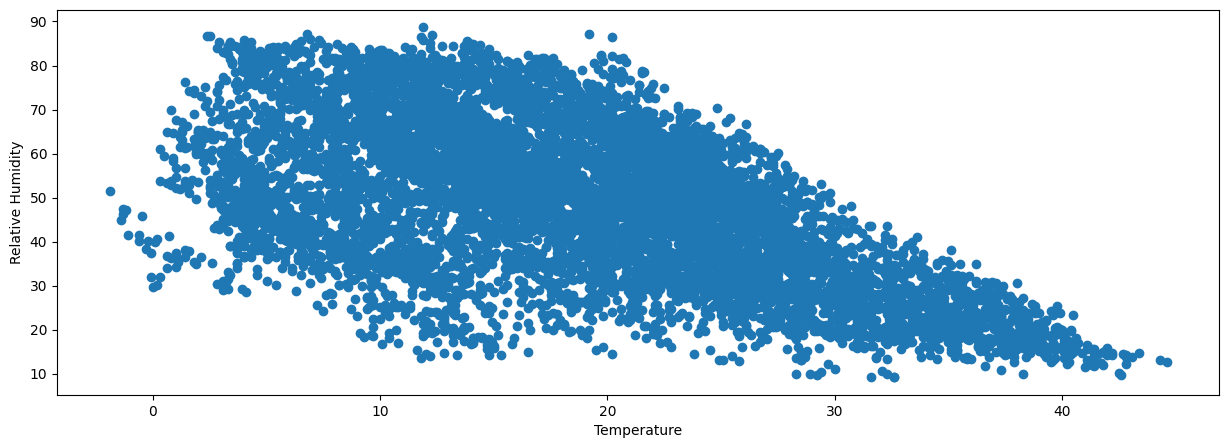

In [ ]:
#  Create a scatter plot for the temperature and relative humidity columns.
plt.figure(figsize=(15,5))
plt.scatter(df['T'],df['RH'])
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.show()

In linear regression, we try to create a straight line which fits most of these points. You can create a regression plot to understand how a line fits most of these points.

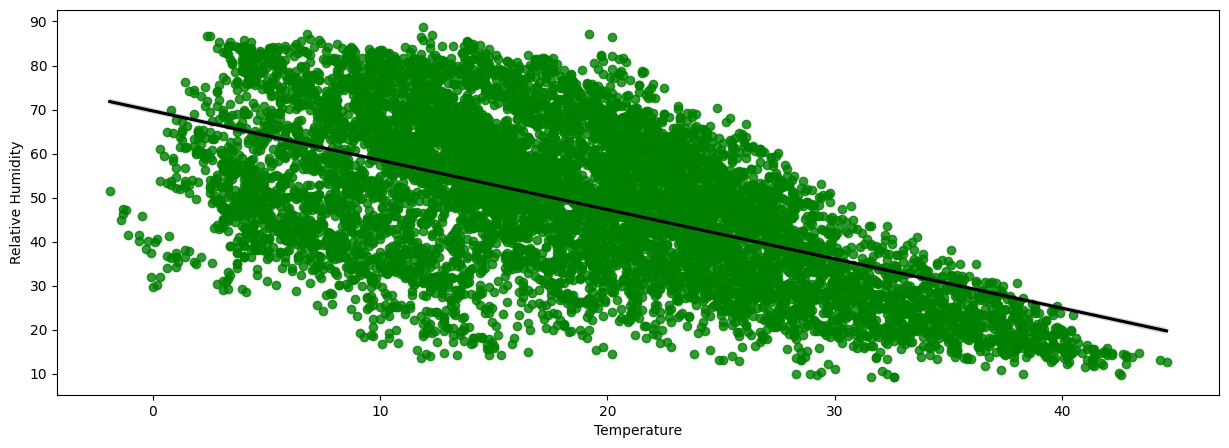

In [ ]:
#Create a regression plot for the temperature and relative humidity columns.
plt.figure(figsize=(15,5))
sns.regplot(x= df['T'],y=df['RH'],color='r',line_kws={'color':'black'},scatter_kws={'color':'g'})
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.show()

As you can see in the regression plot, a straight line having a negative slope passes through these points and tries to fit most of them.

In simple linear regression, our job is to find this straight line which is called the **best fit line**.

Let's try to simulate a few possible lines that can pass through these points in an attempt to fit them.

Let the equation of the best fit line be $$y = mx + c$$

Here,
- $y$ represents the relative humidity values on the $y$-axis

- $x$ represents the temperatures values on the $x$-axis

- $m$ is the slope of the line

- $c$ is the intercept made by the line on the $y$-axis

The above equation can also be written as
$$\text{relative humidity} = m \times \text{temperature} + c$$



---

---

#### Activity 3: Train-Test Split

Now let's deploy a simple linear regression model. We need to split the dataset into a training set and test set wherein the training set is used to train a machine learning model and the test set is used to test the accuracy of predictions on the ML model.

Now there is no fixed rule to what should be the size of training and test sets. However, the training set should always have more instances than the test set. So in general, you can have 70% of instances in the training set and the remaining 30% in the test set. In general, you may split a DataFrame in such a way that a training set contains 67% to 80% of the instances.


To split a DataFrame, we have to:

1. Import the `train_test_split()` function from the `sklearn.model_selection` module.

2. Separate the target variable (to be predicted) from the feature variables (predictors). In this case, we are considering one feature variable that is `T` (temperature).

3. Use the `train_test_split()` function to split the DataFrame into the training and test sets both containing feature variable(s) and the target variable. The function should take the following inputs:
   - An array containing feature variable(s)
   - An array containing target variable
   - Size of the test set i.e., value for the `test_size` parameter
   - Value for the `random_state` parameter

In [ ]:
#  Split the DataFrame into the training and test sets.
from sklearn.model_selection import train_test_split

X = df['T'] # Pandas DataFrame containing only feature variables
y = df['RH'] # Pandas Series containing the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

If you don't specify the `random_state` parameter in your code, then every time you run (or execute) your code, a new random value is generated and the training and test datasets will have different values each time.

However, if a fixed value is assigned like `random_state = 42` then regardless of the number of times you execute your code, the result will be the same i.e., same values in train and test datasets.

Let's understand this concept with the help of an example. Create two NumPy arrays containing 10 values and split them into train and test sets without passing the `random_state` parameter to the `train_test_split()` function.

In [ ]:
array1 = np.arange(1,11)
array2 = np.arange(51,61)
print(array1,array2)

[ 1  2  3  4  5  6  7  8  9 10] [51 52 53 54 55 56 57 58 59 60]


In [ ]:
# Create two NumPy arrays having 10 values. split them into training and test sets without passing the 'random_state' parameter.

array1_train,array1_test,array2_train,array2_test = train_test_split(array1,array2,test_size=0.4)
print(array1_train,array1_test,array2_train,array2_test)

[10  5  8  2  6  7] [3 9 4 1] [60 55 58 52 56 57] [53 59 54 51]


In [ ]:

array1_train,array1_test,array2_train,array2_test = train_test_split(array1,array2,test_size=0.4)
print(array1_train,array1_test,array2_train,array2_test)

[4 9 7 5 6 1] [ 3 10  2  8] [54 59 57 55 56 51] [53 60 52 58]


If you run the above code again and again, you will see the values in the train and test set keep on changing every time.

Now again create two NumPy arrays containing 10 values. Split them into train and test sets and pass the `random_state` parameter as well to the `train_test_split()` function.

In [ ]:
# Create two NumPy arrays containing 10 values. Split them into train and test sets and pass the random_state parameter as well.
array1 = np.arange(1,11)
array2 = np.arange(51,61)
array1_train,array1_test,array2_train,array2_test = train_test_split(array1,array2,test_size=0.4,random_state= 42)
print(array1_train,array1_test,array2_train,array2_test)

[ 8  3 10  5  4  7] [9 2 6 1] [58 53 60 55 54 57] [59 52 56 51]


If you run the above code again and again, you will see the values in the training and test set remain the same.

---

#### Activity 4: Model Training

In simple linear regression, our job is to find this straight line which is called the **best fit line**. So we need to find the best fit line that can fit the most points in the scatter plot between the relative humidity and temperature values.

Let the equation of the best fit line be $$y = mx + c$$

Here,
- $y$ represents the relative humidity values on the $y$-axis
- $x$ represents the temperatures values on the $x$-axis
- $m$ is the slope of the line
- $c$ is the intercept made by the line on the $y$-axis

The above equation can also be written as
$$\text{relative humidity} = m \times \text{temperature} + c$$

Hence, for the best fit line, the slope is given as

$$m = \frac{(x_1 - \bar{x})(y_1 - \bar{y}) + (x_2 - \bar{x})(y_2 - \bar{y}) + (x_3 - \bar{x})(y_3 - \bar{y}) + \dots + (x_n - \bar{x})(y_n - \bar{y})}{(x_1 - \bar{x})^2 + (x_2 - \bar{x})^2 + (x_3 - \bar{x})^2 + \dots + (x_n - \bar{x})^2}$$


$$\Rightarrow m = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$$


where
- $x_i$ is each instance of the feature variable. In this case, $x_i$ represents each temperature value.

- $\bar{x}$ is the average (or mean) value of the feature variable. In this case, $\bar{x}$ is the average temperature value.

- $y_i$ is each instance of the target variable. In this case, $y_i$ represents each relative humidity value.

- $\bar{y}$ is the average (or mean) value of the target variable. In this case, $\bar{y}$ is the average relative humidity value.

- $n$ is the total number of instances.

The above formula may look scary to you, but if you think logically, then it is straightforward. It says
1. Subtract the mean of the feature variable ($\bar{x}$) from each instance ($x$) i.e.
$$(x_1 - \bar{x}), (x_2 - \bar{x}), (x_3 - \bar{x}), \dots , (x_n - \bar{x})$$

2. Similarly, subtract the mean of the target variable ($\bar{y}$) from each instance ($y$) i.e.
$$(y_1 - \bar{y}), (y_2 - \bar{y}), (y_3 - \bar{x}), \dots , (y_n - \bar{y})$$

3. Multiply the above subtractions one-by-one and add them i.e.
$$(x_1 - \bar{x})(y_1 - \bar{y}) + (x_2 - \bar{x})(y_2 - \bar{y}) + (x_3 - \bar{x})(y_3 - \bar{y}) + \dots + (x_n - \bar{x})(y_n - \bar{y})$$

4. Square the values obtained in the first step i.e.
$$(x_1 - \bar{x})^2, (x_2 - \bar{x})^2, (x_3 - \bar{x})^2, \dots , (x_n - \bar{x})^2$$

5. Add all the values obtained in the fourth step i.e.
$$(x_1 - \bar{x})^2 + (x_2 - \bar{x})^2 + (x_3 - \bar{x})^2 + \dots + (x_n - \bar{x})^2$$

6. Finally, divide the sum obtained in the third step by the sum obtained in the fifth step i.e.
$$m = \frac{(x_1 - \bar{x})(y_1 - \bar{y}) + (x_2 - \bar{x})(y_2 - \bar{y}) + (x_3 - \bar{x})(y_3 - \bar{y}) + \dots + (x_n - \bar{x})(y_n - \bar{y})}{(x_1 - \bar{x})^2 + (x_2 - \bar{x})^2 + (x_3 - \bar{x})^2 + \dots + (x_n - \bar{x})^2}$$

The intercept i.e. $c$ is given by
$$c = \bar{y} - m \bar{x}$$


**Note:** The differences between a value and the mean value is also referred to as **residuals** or **errors**.

Now let's create two functions:

1. A function that calculates the errors for the feature and target variables. Let this function be `errors_product()` which doesn't take any input and returns the product of the errors.

2. A function that calculates the squared errors for the feature variable only. Let this function be `squared_errors()` which also doesn't take any input and returns the squared errors.



In [ ]:
# Create the 'errors_product()' and 'squared_errors()' function.
def errors_product():
  product = (X_train - X_train.mean())*(y_train - y_train.mean())
  return product
def squared_errors():
  square = (X_train - X_train.mean())**2
  return square

Now let's calculate the slope and intercept values for the best fit line by applying the formulae mentioned above.

In [ ]:
#  Calculate the slope and intercept values for the best fit line.
m = errors_product().sum()/squared_errors().sum()
c = y_train.mean() - m*X_train.mean()
print("slope:",m,"intercept:",c)

slope: -1.112053910794772 intercept: 69.69110324644876


As you can see, we have obtained the slope and intercept values for the best fit line.

Hence, the required equation of the best fit line is
$$y = -1.1120x + 69.6911$$

or
$$\text{relative humidity} =  -1.1120 \times \text{temperature} + 69.6911$$

which is also the regression line.

Let's plot this line along with the scatter plot to see how well it fits the points.

In [ ]:
(-1.11 * 20)+69.6911

In [ ]:
#  Plot the regression line in the scatter plot between relative humidity and temperature values.
plt.figure(figsize=(18,7))
plt.plot(df['T'],(m*df['T']+c))
plt.scatter(df['T'],df['RH'])
plt.show()

From the naked eye observation, it seems the regression line that we obtained fits pretty well all the points in the scatter plot.

---

#### Activity 5: Prediction

Now let's predict the relative humidity values for the temperature values stored in the test set.

In [ ]:
#  Predict the relative humidity values for the temperature values stored in the test set.
y_predict = m*X_test + c
print(y_predict)

So we have got the predicted relative humidity values.

Also, based on the regression line, we can create a function which takes a temperature (in degree Celsius) value as an input and returns the corresponding relative humidity value.

**Note:** The simple linear regression model that we created is applicable only to the city for which the data is collected. The data doesn't contain global temperature and relative humidity values. Hence, the simple linear regression model cannot be applied for any country, state, region or city in the world.

In [ ]:
# Create a function which takes a temperature (in degree Celsius) value as an input and returns relative humidity.
def get_rh_values(temp):
  rh_value = -1.1 * temp + 69
  return rh_value
get_rh_values(20)

#### Activity 6: Simple Linear Regression Using `sklearn` Module

If you don't like the math behind linear regression, then you can use the `sklearn` (or Scikit-Learn) Python module for machine learning to implement the linear regression model using its `linear_model` module.

However, as a prerequisite to the `sklearn.linear_model` module, the feature and target variable sets should be two-dimensional arrays. Hence, first, you need to reshape the feature and the target variable arrays into two-dimensional arrays as currently they are one-dimensional arrays.

In [ ]:
#  Print the dimensions of the feature and target variable arrays/series.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6269,)
(6269,)
(3088,)
(3088,)


To convert a one-dimensional array into a two-dimensional array, use the `reshape(-1, 1)` function of `numpy` module.

The `reshape(-1, 1)` function does not work on a Pandas series. It works on a NumPy array. Hence, you need to create a NumPy array from a Pandas series. So, either you can convert a Pandas series into a NumPy array using the `array()` function of the `numpy` module or you can use the `values` attribute of the Pandas series object.

In [ ]:
#Create two-dimensional NumPy arrays from one-dimensional Pandas series for the feature and target variables.
print(type(X_train.values))

X_train_reshaped = X_train.values.reshape(-1, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

print(X_train_reshaped.shape)
print(y_train_reshaped.shape)
print(X_test_reshaped.shape)
print(y_test_reshaped.shape)

<class 'numpy.ndarray'>
(6269, 1)
(6269, 1)
(3088, 1)
(3088, 1)


Now, let's deploy a linear regression model using the `sklearn` module. For this, follow the steps given below:

1. Import the `LinearRegression` class from the `sklearn.linear_model` module.
2. Create an object of the `LinearRegression` class.
3. Call the `fit()` function on the `LinearRegression` object with the input parameters as `X_train_reshaped` and `y_train_reshaped`.

The `fit()` function of the `LinearRegression` class will calculate the slope and intercept of the best fit line which you can get by calling the `coef_` and `intercept_` attributes respectively on the `LinearRegression` object.

**Syntax:**
> For slope: `object_name.coef_`

> For intercept: `object_name.intercept_`

As you can see the slope and intercept values are the same as we got earlier without using the `sklearn` module to build a linear regression model.




In [ ]:
#  Deploy linear regression model using the 'sklearn.linear_model' module.

# 1. Import the 'LinearRegression' class from the 'sklearn.linear_model'.
from sklearn.linear_model import LinearRegression

# 2. Create an object of the 'LinearRegression' class.
lin_reg = LinearRegression()

# 3. Call the 'fit()' function
lin_reg.fit(X_train_reshaped, y_train_reshaped)

# 4. Print the slope and intercept values.
print(lin_reg.coef_)
print(lin_reg.intercept_)

[[-1.11205391]]
[69.69110325]


In [ ]:

X = df[['T']] # Pandas DataFrame containing only feature variables
y = df['RH'] # Pandas Series containing the target variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the slope (m) and intercept (b)
m = model.coef_[0]
b = model.intercept_

print(f"Slope (m): {m}")
print(f"Intercept (b): {b}")

# Predict using the model
predictions = model.predict(X)
predictions

Slope (m): -1.1200996344338374
Intercept (b): 69.68361760109673


array([54.45026257, 54.78629246, 56.35443195, ..., 39.55293743,
       37.98479795, 37.76077802])

---

**EXAMPLE**


"Imagine you own a plant nursery, and you want to predict how tall a plant will grow based on the amount of sunlight it gets each day."

Sunlight: Number of hours (input or predictor variable, X).

Plant height: How tall the plant grows (output or response variable, Y).

We're trying to find the relationship between sunlight (X) and height (Y).

Simple linear regression is about finding a straight line (a linear relationship) that best represents the relationship between
X and Y.

The line can be expressed as:
`Y=mX+c`

Where:

Y: Predicted value (e.g., height of the plant).

m: Slope of the line (how much Y changes for a unit change in X).

c: Intercept (value of Y when X=0).

In [ ]:
# Example data
data_plant = {
    "Sunlight Hours": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Plant Height (cm)": [2, 3, 5, 7, 8, 10, 11, 13, 14]
}
df_plant = pd.DataFrame(data_plant)
df_plant

,Sunlight Hours,Plant Height (cm)
0,1,2
1,2,3
2,3,5
3,4,7
4,5,8
5,6,10
6,7,11
7,8,13
8,9,14


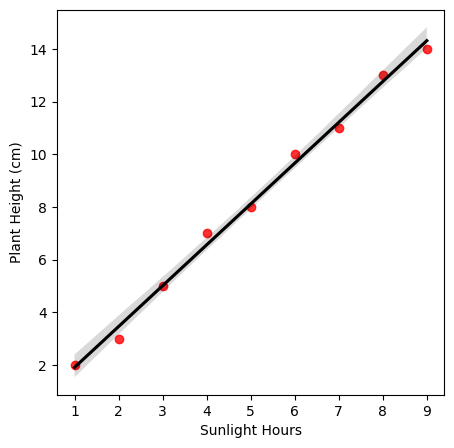

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(5,5))
sns.regplot(x= df['Sunlight Hours'],y=df['Plant Height (cm)'],color='r',line_kws={'color':'black'})
plt.xlabel("Sunlight Hours")
plt.ylabel("Plant Height (cm)")
plt.show()


The goal is to draw the "best-fit line" that goes as close to the points as possible.

Once we have the line, we can use it to predict:

If a plant gets 6 hours of sunlight, we can plug `X=6` into the equation to predict its height.


**Intuitive Explanation of Slope and Intercept:**


- Slope (m): How much plant height increases per additional hour of sunlight.
Example: If m=2, then for every 1 extra hour of sunlight, the plant grows 2 cm taller.
- Intercept (c): Starting height when there's no sunlight (X=0).


**Error and Best Fit Line:**

- Data points don't always lie perfectly on the line. The **"error"** is the difference between the actual and predicted values.
- The regression line minimizes the total error (measured as the sum of squared differences).

**KEYPOINT**

Simple linear regression finds the relationship between two variables to make predictions. It's like drawing a straight line that best fits the data points to answer, "How does X affect Y?"